# Experiment Overview: Method Comparison

Compare multiple similarity methods side-by-side:
- **Summary statistics** for each method
- **Performance rankings** across metrics
- **Method correlations** (do methods agree?)
- **Metric distributions** and outlier analysis

For detailed single-method analysis with query visualization, see `method_analysis.ipynb`.

In [2]:
import sys
print(sys.executable)
print(sys.path)

d:\sim-bench\.venv\Scripts\python.exe
['C:\\Program Files\\Python311\\python311.zip', 'C:\\Program Files\\Python311\\DLLs', 'C:\\Program Files\\Python311\\Lib', 'C:\\Program Files\\Python311', 'd:\\sim-bench\\.venv', '', 'd:\\sim-bench\\.venv\\Lib\\site-packages', 'd:\\sim-bench\\.venv\\Lib\\site-packages\\win32', 'd:\\sim-bench\\.venv\\Lib\\site-packages\\win32\\lib', 'd:\\sim-bench\\.venv\\Lib\\site-packages\\Pythonwin']


In [3]:
# Force clean import
import sys

# Add project root
sys.path.insert(0, 'd:\\sim-bench')

# Nuclear option: Clear ALL sim_bench related modules
to_delete = [key for key in sys.modules.keys() if key.startswith('sim_bench')]
for key in to_delete:
    del sys.modules[key]

print(f"Cleared {len(to_delete)} cached modules")
print(f"sys.path[0] = {sys.path[0]}")


Cleared 0 cached modules
sys.path[0] = d:\sim-bench


In [4]:
# %reset
from sim_bench.analysis.utils import get_project_root

In [5]:
# === Imports ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sim_bench.analysis.utils import get_project_root
from sim_bench.analysis.io import load_metrics, load_per_query
from sim_bench.analysis.export import export_notebook_to_pdf, archive_notebook

sns.set_style('whitegrid')

# === Configuration ===
PROJECT_ROOT = get_project_root()

# Experiment settings
EXPERIMENT_DIR = PROJECT_ROOT / "outputs" / "baseline_runs" / "comprehensive_baseline" / "2025-10-24_01-10-45"
METHODS = ["emd", "deep", "sift_bovw"]  # Methods to compare

# === Output Options ===
EXPORT_PDF = True  # Export entire notebook to PDF

# === Validation ===
if not EXPERIMENT_DIR.exists():
    raise FileNotFoundError(f"Experiment directory not found: {EXPERIMENT_DIR}")

# Validate all methods exist
for method in METHODS:
    if not (EXPERIMENT_DIR / method).exists():
        available = [d.name for d in EXPERIMENT_DIR.iterdir() if d.is_dir() and not d.name.startswith('.')]
        raise FileNotFoundError(
            f"Method '{method}' not found in {EXPERIMENT_DIR}\n"
            f"Available: {available}"
        )

print(f"✓ Configuration validated")
print(f"  Experiment: {EXPERIMENT_DIR.relative_to(PROJECT_ROOT)}")
print(f"  Methods: {', '.join(METHODS)}")
print(f"  Export PDF: {EXPORT_PDF}")


✓ Configuration validated
  Experiment: outputs\baseline_runs\comprehensive_baseline\2025-10-24_01-10-45
  Methods: emd, deep, sift_bovw
  Export PDF: True


## 1. Load Data

In [17]:
# Load metrics for all methods
metrics_data = {}
for method in METHODS:
    try:
        df = load_metrics(method, EXPERIMENT_DIR)
        metrics_data[method] = df
        print(f"✓ {method}: {len(df)} metrics")
        # Handle backward compatibility
        if 'map_full' in df.columns and 'map' not in df.columns:
            df['map'] = df['map_full']
        if 'prec@10' in df.columns and 'precision@10' not in df.columns:
            df['precision@10'] = df['prec@10']        
    except FileNotFoundError:
        print(f"⚠ {method}: metrics.csv not found, skipping")

# Create summary DataFrame
summary_rows = []
for method, df in metrics_data.items():
    row = {'method': method}
    row.update(df.iloc[0].to_dict())
    summary_rows.append(row)

df_summary = pd.DataFrame(summary_rows)
print(f"\n✓ Loaded {len(metrics_data)} methods")
df_summary


✓ emd: 1 metrics
✓ deep: 1 metrics
✓ sift_bovw: 1 metrics

✓ Loaded 3 methods


,method,map_full,map@10,map@50,recall@1,recall@10,prec@10,num_queries,num_gallery,created_at,map,precision@10
0,emd,0.0,0.224987,0.0,0.299128,0.511737,0.0,1491,1491,2025-10-24T01:24:08.572185,0.0,0.0
1,deep,0.0,0.818236,0.0,0.869886,0.965795,0.0,1491,1491,2025-10-24T01:26:08.920112,0.0,0.0
2,sift_bovw,0.0,0.366917,0.0,0.452046,0.658618,0.0,1491,1491,2025-10-24T01:28:40.087304,0.0,0.0


## 2. Performance Summary

In [19]:
# Extract key metrics for comparison
key_metrics = ['recall@1', 'recall@10', 'map@10']
available_metrics = [m for m in key_metrics if m in df_summary.columns]

if not available_metrics:
    # Fallback: use all numeric columns except method
    available_metrics = df_summary.select_dtypes(include=[np.number]).columns.tolist()

# Create comparison table
df_comparison = df_summary[['method'] + available_metrics].copy()
df_comparison = df_comparison.set_index('method')

# Highlight best values
print("Performance Comparison (higher is better):")
df_comparison.style.highlight_max(axis=0, color='green')


Performance Comparison (higher is better):


,recall@1,recall@10,map@10
method,,,
emd,0.299128,0.511737,0.224987
deep,0.869886,0.965795,0.818236
sift_bovw,0.452046,0.658618,0.366917


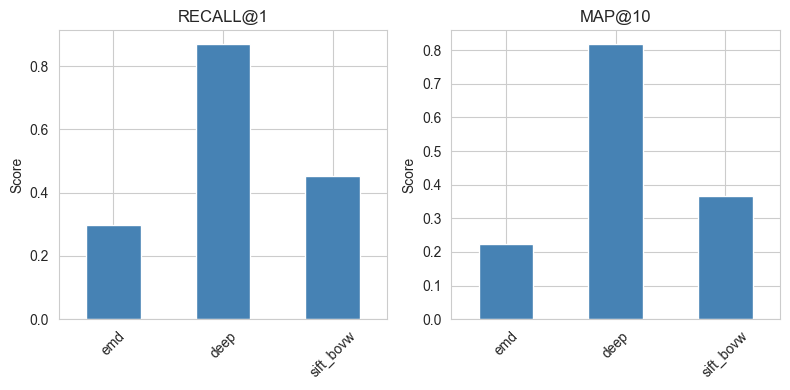

In [8]:
# Visualize performance across methods
if len(available_metrics) > 0:
    fig, axes = plt.subplots(1, min(4, len(available_metrics)), figsize=(4 * min(4, len(available_metrics)), 4))
    if len(available_metrics) == 1:
        axes = [axes]
    
    for idx, metric in enumerate(available_metrics[:4]):
        ax = axes[idx]
        df_comparison[metric].plot(kind='bar', ax=ax, color='steelblue')
        ax.set_title(f'{metric.upper()}')
        ax.set_ylabel('Score')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠ No metrics available for visualization")


C:\Users\Jonathan Hexner\AppData\Local\Temp\ipykernel_19804\348298130.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=methods, patch_artist=True)


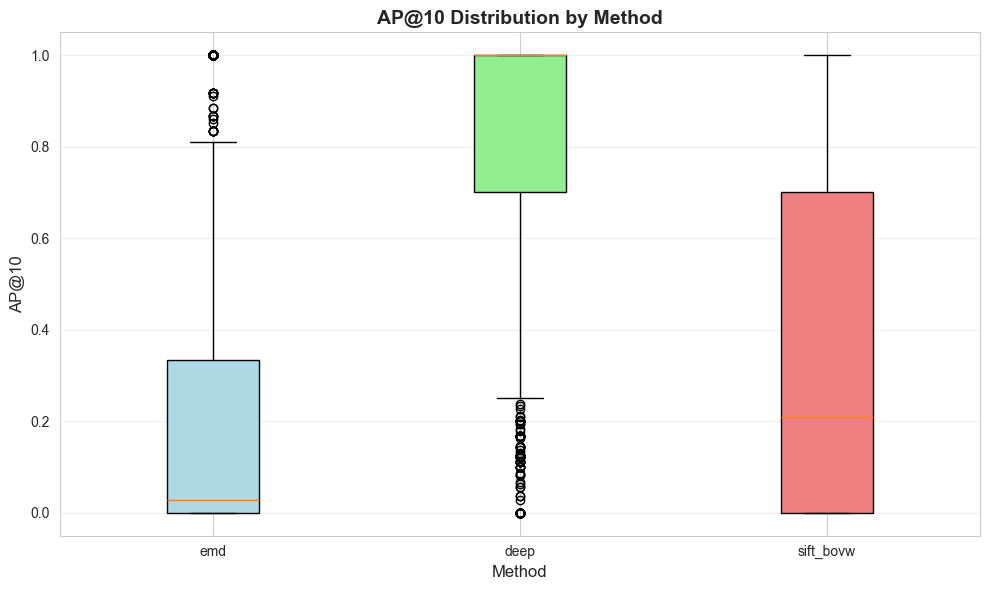


AP@10 Statistics:
emd             | Mean: 0.2252 | Median: 0.0278 | Std: 0.3293
deep            | Mean: 0.8203 | Median: 1.0000 | Std: 0.2952
sift_bovw       | Mean: 0.3679 | Median: 0.2083 | Std: 0.3911


{'emd': array([0.125   , 0.      , 0.      , ..., 0.05    , 0.166667, 0.25    ]),
 'deep': array([0.45    , 0.7     , 0.642857, ..., 0.5     , 0.125   , 0.083333]),
 'sift_bovw': array([0.666667, 0.75    , 0.      , ..., 0.5     , 0.      , 0.125   ])}

In [9]:
def plot_metric_comparison(methods, experiment_dir, metric='ap@10', figsize=(10, 6)):
    """
    Compare a metric across methods using box plots.
    
    Args:
        methods: List of method names
        experiment_dir: Path to experiment directory
        metric: Metric column name to compare
        figsize: Figure size
    """
    # Load per-query data for all methods
    data = {}
    for method in methods:
        df = load_per_query(method, experiment_dir)
        data[method] = df[metric].values
    
    # Create box plot
    fig, ax = plt.subplots(figsize=figsize)
    
    data_to_plot = [data[method] for method in methods]
    bp = ax.boxplot(data_to_plot, labels=methods, patch_artist=True)
    
    # Color boxes
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors[:len(methods)]):
        patch.set_facecolor(color)
    
    ax.set_ylabel(metric.upper(), fontsize=12)
    ax.set_xlabel('Method', fontsize=12)
    ax.set_title(f'{metric.upper()} Distribution by Method', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{metric.upper()} Statistics:")
    for method in methods:
        values = data[method]
        print(f"{method:15s} | Mean: {values.mean():.4f} | Median: {np.median(values):.4f} | Std: {values.std():.4f}")
    
    return data


# Use it
plot_metric_comparison(METHODS, EXPERIMENT_DIR, metric='ap@10')

## 3. Method Rankings

In [10]:
# Rank methods by each metric
df_ranks = df_comparison.rank(ascending=False, method='min').astype(int)
df_ranks.columns = [f'{col}_rank' for col in df_ranks.columns]

# Add average rank
df_ranks['avg_rank'] = df_ranks.mean(axis=1)
df_ranks = df_ranks.sort_values('avg_rank')

print("Method Rankings (1=best):")
df_ranks


Method Rankings (1=best):


,recall@1_rank,map@10_rank,avg_rank
method,,,
deep,1,1,1.0
sift_bovw,2,2,2.0
emd,3,3,3.0


## 4. Method Correlation Analysis

In [15]:
df.head()

,query_idx,query_path,group_id,num_relevant,ap_full,ap@10,recall@10
0,0,D:\Similar Images\DataSets\InriaHolidaysFull\1...,1000,2,0.666667,0.666667,1.0
1,1,D:\Similar Images\DataSets\InriaHolidaysFull\1...,1000,2,0.750000,0.750000,1.0
2,2,D:\Similar Images\DataSets\InriaHolidaysFull\1...,1000,2,0.082043,0.000000,1.0
3,3,D:\Similar Images\DataSets\InriaHolidaysFull\1...,1001,1,1.000000,1.000000,1.0
4,4,D:\Similar Images\DataSets\InriaHolidaysFull\1...,1001,1,1.000000,1.000000,1.0


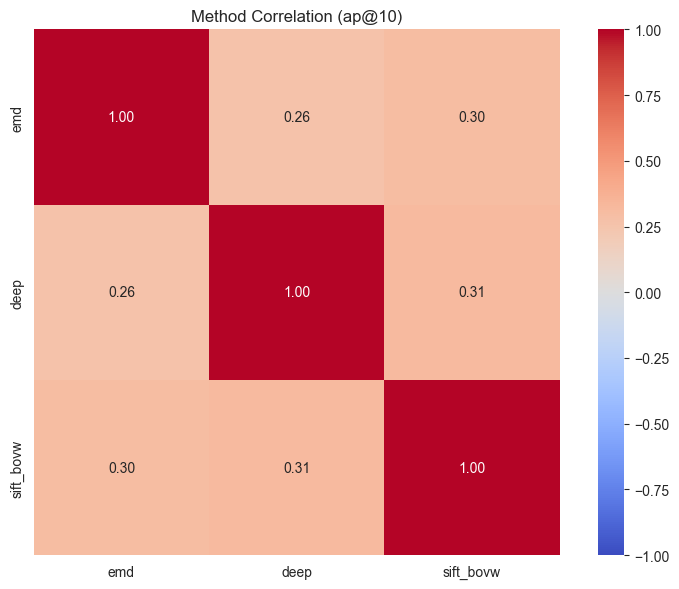


Correlation analysis based on: ap@10
High correlation = methods agree on query difficulty


In [16]:
compare_metric = 'ap@10'
# Load per-query results to analyze correlations
per_query_data = {}
for method in METHODS:
    try:
        df = load_per_query(method, EXPERIMENT_DIR)
        per_query_data[method] = df
    except FileNotFoundError:
        print(f"⚠ {method}: per_query.csv not found")

if len(per_query_data) >= 2:
    # Choose a metric to compare (e.g., first available numeric column)
    
    # Create comparison DataFrame
    df_compare = pd.DataFrame()
    for method, df in per_query_data.items():
        if compare_metric in df.columns:
            df_compare[method] = df[compare_metric].values
    
    # Compute correlation
    corr_matrix = df_compare.corr()
    
    # Visualize
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                vmin=-1, vmax=1, square=True)
    plt.title(f'Method Correlation ({compare_metric})')
    plt.tight_layout()
    plt.show()
    
    print(f"\nCorrelation analysis based on: {compare_metric}")
    print("High correlation = methods agree on query difficulty")

else:
    print("⚠ Need at least 2 methods for correlation analysis")


## 5. Summary

In [12]:
print("=" * 60)
print("EXPERIMENT SUMMARY")
print("=" * 60)
print(f"Experiment: {EXPERIMENT_DIR.name}")
print(f"Methods compared: {len(METHODS)}")
print(f"\nBest method by average rank: {df_ranks.index[0]}")
print(f"\nFor detailed analysis of a specific method, see method_analysis.ipynb")


EXPERIMENT SUMMARY
Experiment: 2025-10-24_01-10-45
Methods compared: 3

Best method by average rank: deep

For detailed analysis of a specific method, see method_analysis.ipynb


## Export to PDF (Optional)


In [13]:
# === Export to PDF and Archive Notebook (Optional) ===
if EXPORT_PDF:
    notebook_path = PROJECT_ROOT / "sim_bench" / "analysis" / "methods_comparison.ipynb"
    output_dir = EXPERIMENT_DIR / "analysis_reports"
    
    # Archive the notebook (preserves configuration and code)
    try:
        archived_path = archive_notebook(notebook_path, output_dir=output_dir, prefix="methods_comparison")
        print(f"✓ Archived notebook: {archived_path.name}")
    except Exception as e:
        print(f"⚠ Notebook archive failed: {e}")
    
    # Export to PDF
    try:
        pdf_path = export_notebook_to_pdf(notebook_path, output_dir=output_dir, prefix="methods_comparison")
        print(f"✓ Exported to PDF: {pdf_path.name}")
        print(f"\n📁 Output location: {output_dir.relative_to(PROJECT_ROOT)}")
    except ImportError:
        print("⚠ PDF export requires: pip install nbconvert[webpdf]")
    except Exception as e:
        print(f"⚠ PDF export failed: {e}")
else:
    print("PDF export disabled. Set EXPORT_PDF = True in configuration to enable.")


✓ Archived notebook: methods_comparison_methods_comparison_20251025_202824.ipynb
✓ Exported to PDF: methods_comparison_methods_comparison_20251025_202825.pdf

📁 Output location: outputs\baseline_runs\comprehensive_baseline\2025-10-24_01-10-45\analysis_reports
